<a href="https://colab.research.google.com/github/gauthamramesh3110/image_processing_scripts/blob/main/Bounding_Box_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import xml.etree.ElementTree as et
import keras.backend as K
import pickle
from tqdm import tqdm
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

ROOT_DIR = '/content/drive/MyDrive/Datasets/license-plate-detection'
IMG_DIMS = (224, 224, 3)
OBJECTS = ['license_plate']

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Datasets/license-plate-detection/archives/car.tar.xz /content
!tar xf /content/drive/MyDrive/Datasets/license-plate-detection/archives/car.tar.xz

In [ ]:
!rm -rf /content/license-plate-car-cropped/
!rm /content/license-plate-car-cropped.tar.xz

rm: cannot remove '/content/license-plate-car-cropped.tar.xz': No such file or directory


In [ ]:
class helpers:
  @staticmethod
  def display_boxes(image, annotations):

    if np.max(image) > 1:
      image = np.array(image, dtype='uint8')

    annotations = [[ int(i*IMG_DIMS[0]) for i in annotations ]]
    for annotation in annotations:
      top_left = (annotation[0], annotation[1])
      bottom_right = (annotation[2], annotation[3])
      image = cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(image)
    print()
  
  @staticmethod
  def pad_and_resize(image, toggle, output):
    [xmin, ymin, w, h] = output

    height = image.shape[0]
    width = image.shape[1]

    vertical_padding = max(0, width-height)
    horizontal_padding = max(0, height-width)

    top = vertical_padding if toggle else 0
    bottom = vertical_padding if not toggle else 0
    left = horizontal_padding if toggle else 0
    right = horizontal_padding if not toggle else 0

    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)
    image = cv2.resize(image, IMG_DIMS[:2])

    xmin += left
    ymin += top

    output = [xmin, ymin, w, h]
    output = np.array(output) / max(width, height)

    return image, output

  @staticmethod
  def save_pickle(data, filename):
    if os.path.exists(filename):
      os.remove(filename)
    file = open(filename, 'wb')
    pickle.dump(data, file)
    file.close()

  @staticmethod
  def load_pickle(filename):
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()
    return data

  @staticmethod
  def get_output_list(annotation_filepath):
    annotation_file = open(annotation_filepath, 'r')
    annotations = annotation_file.read()
    annotations = annotations.split(' ')


    image_filename = annotations[0]
    image_width = int(annotations[1])
    image_height = int(annotations[2])
    
    [xmin, ymin, xmax, ymax] = list(map(int, annotations[3:]))

    xmin /= image_width
    ymin /= image_height
    xmax /= image_width
    ymax /= image_height

    return image_filename, [xmin, ymin, xmax, ymax]

  @staticmethod
  def get_mirror(image, output):
    image = cv2.flip(image, 1)
    [xmin, ymin, xmax, ymax] = output
    xmin_new = 1 - xmax
    xmax_new = 1 - xmin
    return image, [xmin_new, ymin, xmax_new, ymax]

  @staticmethod
  def get_annotations(annotation_filepath, objects):

    # GET XML TREE AND ROOT NODE
    tree = et.parse(annotation_filepath)
    root = tree.getroot()

    # GET IMAGE DIMENSIONS
    image_width = int( root.find('./size/width').text )
    image_height = int( root.find('./size/height').text )

    # GET IMAGE FILENAME
    image_filename = root.find('./filename').text

    # ANNOTATION STORAGE DICTIONARY
    annotations = dict()

    # LOOP THROUGH ALL OBJECTS IN FILE AND ADD BBOX DIMENSIONS TO ANNOTATIONS DICTIONARY
    for annotation in root.findall('./object'):
      name = annotation.find('./name').text # NAME OF THE OBJECT

      # TRANSFORM THE COORDINATES INTO RATIOS WITH RESPECT TO THE CORRESPONDING DIMENSION
      xmin =  int( annotation.find('./bndbox/xmin').text ) 
      ymin =  int( annotation.find('./bndbox/ymin').text ) 
      xmax =  int( annotation.find('./bndbox/xmax').text ) 
      ymax =  int( annotation.find('./bndbox/ymax').text )

      # SAVE TO DICTIONARY
      annotations[name] = [xmin, ymin, xmax, ymax]
    
    # GENERATE AN OUTPUT ARRAY CONSISTING ONLY OF THE MENTIONED OBJECTS
    output = []
    for object_name in objects:
      output += annotations[object_name]

    return image_filename, output 

In [ ]:
def get_data(annotations_dirpath, image_dirpath, objects, generate_new, data_filename):

  if not generate_new:
    return helpers.load_pickle(data_filename)

  X = []
  y = []
  toggle = False

  for annotation_filename in tqdm(os.listdir(annotations_dirpath)):


    # GENERATE ANNOTATION FILEPATH
    annotation_filepath = os.path.join(annotations_dirpath, annotation_filename)


    # GET IMAGE FILENAME AND OUTPUT LIST
    # image_filename, output = helpers.get_annotations(annotation_filepath, objects)
    image_filename, output = helpers.get_output_list(annotation_filepath)
    # print('check')
    # continue

    # GENERATE IMAGE FILEPATH
    image_filepath = os.path.join(image_dirpath, image_filename)

    # READ IMAGE
    image = load_img(image_filepath, target_size=IMG_DIMS[:2])
    # image = cv2.imread(image_filepath, cv2.IMREAD_COLOR)

    # CONVERT IMAGE TO ARRAY
    image = img_to_array(image)
    # image, output = helpers.pad_and_resize(image, toggle, output)
    # toggle = !toggle

    X.append(image)
    y.append(output)

    image_mirror, output_mirror = helpers.get_mirror(image, output)

    X.append(image_mirror)
    y.append(output_mirror)
  
  X = np.array(X, dtype='float32')
  y = np.array(y)

  helpers.save_pickle([X,y], data_filename)

  return [X,y]

In [ ]:
def get_vgg(output_size, optimizer, loss):
  
  # GET VGG16 MODEL WITH IMAGENET WEIGHTS, AND WITHOUT TOP LAYER
  vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=IMG_DIMS))

  # FREEZE ALL LAYERS IN VGG
  vgg.trainable = False

  # FLATTEN MAX-POOL LAYER TO ALLOW DENSE TO CONNECT
  flatten = vgg.output
  flatten = Flatten()(flatten)

  # ADD FULLY CONNECTED LAYERS TO ALLOW TRAINING
  bboxHead = Dense(128)(flatten)
  bboxHead = LeakyReLU()(bboxHead)
  bboxHead = Dropout(0.2)(bboxHead)

  bboxHead = Dense(32)(bboxHead)
  bboxHead = LeakyReLU()(bboxHead)
  bboxHead = Dropout(0.2)(bboxHead)

  # FINAL OUTPUT LAYER WITH OUTPUT SIZE CORRESPONDING TO NUMBER OF OBJECTS
  bboxHead = Dense(output_size, activation="sigmoid")(bboxHead)

  # CONSTRUCT MODEL WITH VGG INPUT AND SIGMOID OUTPUT
  model = Model(inputs=vgg.input, outputs=bboxHead)

  # COMPILE MODEL
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

def get_custom(output_size, optimizer, loss):
  model = Sequential()

  model.add(Conv2D(16, (3,3), input_shape = IMG_DIMS, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), activation='relu' ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(256, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(512, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  # model.add(Conv2D(1024, (3,3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))

  model.add(Flatten())
  model.add(Dropout(0.2))
  model.add(Dense(16, activation='relu'))

  model.add(Dropout(0.2))
  model.add(Dense(output_size, activation='sigmoid'))

  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

def calculate_iou( target_boxes , pred_boxes ):
    xA = K.maximum( target_boxes[ ... , 0], pred_boxes[ ... , 0] )
    yA = K.maximum( target_boxes[ ... , 1], pred_boxes[ ... , 1] )
    xB = K.minimum( target_boxes[ ... , 2], pred_boxes[ ... , 2] )
    yB = K.minimum( target_boxes[ ... , 3], pred_boxes[ ... , 3] )
    interArea = K.maximum( 0.0 , xB - xA ) * K.maximum( 0.0 , yB - yA )
    boxAArea = (target_boxes[ ... , 2] - target_boxes[ ... , 0]) * (target_boxes[ ... , 3] - target_boxes[ ... , 1])
    boxBArea = (pred_boxes[ ... , 2] - pred_boxes[ ... , 0]) * (pred_boxes[ ... , 3] - pred_boxes[ ... , 1])
    iou = interArea / ( boxAArea + boxBArea - interArea )
    return iou

def custom_loss( y_true , y_pred ):
    mse = tf.losses.mean_squared_error( y_true , y_pred ) 
    iou = calculate_iou( y_true , y_pred ) 
    return mse + ( 1 - iou )

def iou_metric( y_true , y_pred ):
    return calculate_iou( y_true , y_pred ) 

In [ ]:
[X, y] = get_data(
  annotations_dirpath = '/content/car/annotations',
  image_dirpath = '/content/car/images',
  objects = OBJECTS,
  generate_new = True,
  data_filename = '/content/drive/MyDrive/Datasets/license-plate-detection/car.pkl'
)

100%|██████████| 123/123 [00:00<00:00, 417.99it/s]



[0.78333333 0.59666667 0.07666667 0.37333333]
(246, 224, 224, 3)
(246, 4)


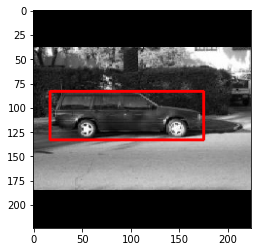

In [ ]:
index = 1
test_image, test_output = X[index], y[index]
helpers.display_boxes(test_image, test_output)

print(test_output)

print(X.shape)
print(y.shape)

In [ ]:
print(y[4])

[0.24691358 0.73045267 0.2037037  0.05658436]


In [ ]:
model = get_vgg(
  output_size=len(OBJECTS)*4, 
  optimizer='adam',
  loss='mse'
)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
X = preprocess_input(X) 

In [ ]:
model.fit(X, y, batch_size=64, epochs=15, validation_split=0.1)

Epoch 1/15
4/4 [==============================] - 1s 243ms/step - loss: 0.2222 - accuracy: 0.5872 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 2/15
4/4 [==============================] - 1s 139ms/step - loss: 0.1024 - accuracy: 0.9953 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - 1s 136ms/step - loss: 0.1019 - accuracy: 0.9880 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - 1s 134ms/step - loss: 0.1017 - accuracy: 0.9912 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 5/15
4/4 [==============================] - 1s 133ms/step - loss: 0.1022 - accuracy: 0.9880 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 6/15
4/4 [==============================] - 1s 135ms/step - loss: 0.1084 - accuracy: 0.9964 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 1s 135ms/step - loss: 0.1016 - accuracy: 0.9943 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 8/15
4/4 [====

In [ ]:
TEST_DIR = os.path.join(ROOT_DIR, 'test_images')
X_test = []

for filename in os.listdir(TEST_DIR):
  filepath = os.path.join(TEST_DIR, filename)

  image = load_img(filepath, target_size=IMG_DIMS[:2])
  test_image = img_to_array(image)
  X_test.append(test_image)

X_test = np.array(X_test, dtype='float32')
X_test_pred = preprocess_input(X_test)
y_test = model.predict(X_test)

In [ ]:
print(y_test)

[[1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]


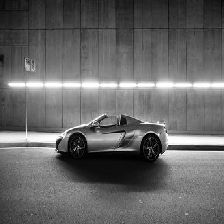

In [ ]:
index = 6
helpers.display_boxes(X_test[index], y_test[index])

In [ ]:
d = model.layers[-1]

In [ ]:
d.